In [1]:
# ============================================================================
# UPLOAD AND EXTRACT LOCAL DATA
# ============================================================================

from google.colab import files
import zipfile
import os

# Upload the file
print("Please upload dev_phase.zip:")
uploaded = files.upload()

# Check what was uploaded
print("\nUploaded files:")
for filename in uploaded.keys():
    print(f"  {filename} ({len(uploaded[filename])} bytes)")

# Extract the zip
print("\nExtracting...")
with zipfile.ZipFile('dev_phase.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

print("Extracted!")

# Check structure
print("\nDirectory structure:")
for root, dirs, files in os.walk('./data'):
    level = root.replace('./data', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files)-5} more files')

print("\nData ready!")

Please upload dev_phase.zip:


Saving dev_phase.zip to dev_phase.zip

Uploaded files:
  dev_phase.zip (18925651 bytes)

Extracting...
Extracted!

Directory structure:
data/
  dev_phase/
    subtask1/
      dev/
        khm.csv
        ori.csv
        hau.csv
        spa.csv
        deu.csv
        ... and 17 more files
      train/
        khm.csv
        ori.csv
        hau.csv
        spa.csv
        deu.csv
        ... and 17 more files
    subtask2/
      dev/
        khm.csv
        ori.csv
        hau.csv
        spa.csv
        deu.csv
        ... and 17 more files
      train/
        khm.csv
        ori.csv
        hau.csv
        spa.csv
        deu.csv
        ... and 17 more files
    subtask3/
      dev/
        khm.csv
        ori.csv
        hau.csv
        spa.csv
        deu.csv
        ... and 13 more files
      train/
        khm.csv
        ori.csv
        hau.csv
        spa.csv
        deu.csv
        ... and 13 more files
  __MACOSX/
    ._dev_phase
    dev_phase/
      ._subtask3
      ._sub

In [1]:
# ============================================================================
# PART 1: SETUP & IMPORTS
# ============================================================================

!pip install -q datasets transformers accelerate scikit-learn

import os
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset, concatenate_datasets, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\nSetup complete")

Device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.17 GB

Setup complete


In [2]:
# ============================================================================
# PART 2: CONFIGURATION
# ============================================================================

class Config:
    # Languages (22 total)
    ALL_LANGS = ['amh', 'arb', 'deu', 'eng', 'fas', 'hau', 'hin',
                 'ita', 'nep', 'spa', 'tur', 'urd', 'zho','ben',
                 'khm','mya','ori','pan','pol','rus','swa','tel']

    # All models
    MODELS = {
        'mdeberta': 'microsoft/mdeberta-v3-base',
        'xlm_r': 'FacebookAI/xlm-roberta-base',
        'infoxlm': 'microsoft/infoxlm-base',
        'xlm_r_large': 'FacebookAI/xlm-roberta-large',
        'rembert': 'google/rembert',
        }

    # Languages with severe class imbalance
    IMBALANCED_LANGS = ['hin', 'urd', 'fas', 'hau', 'amh']

    # Training parameters
    MAX_LENGTH = 128
    BATCH_SIZE = 64
    GRADIENT_ACCUMULATION = 1
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 10
    WARMUP_RATIO = 0.06
    WEIGHT_DECAY = 0.01

    # Paths (LOCAL)
    OUTPUT_DIR = './outputs'
    DATA_BASE_PATH = './data/dev_phase/subtask1'
    TRAIN_PATH = './data/dev_phase/subtask1/train'
    DEV_PATH = './data/dev_phase/subtask1/dev'

    # Train/Val split
    VAL_SPLIT_RATIO = 0.2

    # Focal Loss params
    FOCAL_ALPHA = 0.25
    FOCAL_GAMMA = 2.0

print("Configuration loaded")
print(f"Languages: {len(Config.ALL_LANGS)}")
print(f"Models: {list(Config.MODELS.keys())}")
print(f"Data path: {Config.DATA_BASE_PATH}")

Configuration loaded
Languages: 22
Models: ['mdeberta', 'xlm_r', 'infoxlm', 'xlm_r_large', 'rembert']
Data path: ./data/dev_phase/subtask1


In [3]:
# ============================================================================
# PART 3: FOCAL LOSS (For class imbalance)
# ============================================================================

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler

class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance

    Formula: FL(p_t) = -α(1-p_t)^γ * log(p_t)

    Args:
        alpha: Weighting factor (0-1) to balance classes
        gamma: Focusing parameter (reduces loss for well-classified examples)
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()


# Custom Trainer that uses Focal Loss
class FocalLossTrainer(Trainer):

    def __init__(self, *args, use_focal_loss=True, focal_alpha=0.25, focal_gamma=2.0, **kwargs):
        """
        use_focal_loss: Whether to use focal loss (True) or standard CE loss (False)
        focal_alpha: Alpha parameter for focal loss
        focal_gamma: Gamma parameter for focal loss
        """

        self.use_focal_loss = use_focal_loss
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma

        # Initialize focal loss if needed
        if self.use_focal_loss:
            self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)


        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):

        # Extract labels
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Compute loss
        if self.use_focal_loss:
            loss = self.focal_loss(logits, labels)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

# Create WeightedRandomSampler for the dataset
def create_weighted_sampler(dataset, sample_weights):

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

In [4]:
# ============================================================================
# PART 4: DATA LOADING (FROM LOCAL FILES)
# ============================================================================

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Language order matters for reproducibility, not performance
LANGUAGE_ORDER = sorted(Config.ALL_LANGS)

def load_local_language_data(lang, base_path='./data/dev_phase/subtask1'):

    train_file = f'{base_path}/train/{lang}.csv'

    if not os.path.exists(train_file):
        raise FileNotFoundError(f"Train file not found: {train_file}")

    # Load CSV
    df = pd.read_csv(train_file)

    # Check required columns
    required_cols = ['text', 'polarization']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"CSV must have columns: {required_cols}, found: {df.columns.tolist()}")

    # Split train/val with stratification
    train_df, val_df = train_test_split(
        df,
        test_size=0.2,
        random_state=SEED,
        stratify=df['polarization']  # Maintain class balance
    )

    # Convert to HuggingFace Dataset
    train_ds = Dataset.from_pandas(train_df[['text', 'polarization']], preserve_index=False)
    val_ds = Dataset.from_pandas(val_df[['text', 'polarization']], preserve_index=False)

    return train_ds, val_ds

# Load and concatenate data from multiple languages
def load_multilingual_data(languages=None, print_stats=True, base_path='./data/dev_phase/subtask1'):

    if languages is None:
        languages = LANGUAGE_ORDER  # Use sorted order

    all_train = []
    all_val = []

    print(f"\n{'='*80}")
    print(f"LOADING LOCAL DATA: {len(languages)} languages")
    print(f"Language order: {', '.join(languages)}")
    print(f"{'='*80}\n")

    for lang in languages:
        try:
            # Load language data
            train_ds, val_ds = load_local_language_data(lang, base_path)

            # Add language identifier
            def add_lang_id(example):
                example['language'] = lang
                return example

            train_ds = train_ds.map(add_lang_id)
            val_ds = val_ds.map(add_lang_id)

            all_train.append(train_ds)
            all_val.append(val_ds)

            if print_stats:
                n_train = len(train_ds)
                n_val = len(val_ds)
                polarized_ratio = sum(train_ds['polarization']) / n_train * 100
                print(f"{lang.upper():>3} | Train: {n_train:>4} | Val: {n_val:>3} | "
                      f"Polarized: {polarized_ratio:>5.1f}%")

        except Exception as e:
            print(f"Failed to load {lang}: {e}")
            continue

    if not all_train:
        raise ValueError("No data loaded! Check your file paths.")

    # Concatenate all languages
    from datasets import concatenate_datasets
    train_combined = concatenate_datasets(all_train)
    val_combined = concatenate_datasets(all_val)

    print(f"\n{'='*80}")
    print(f"TOTAL | Train: {len(train_combined):>5} | Val: {len(val_combined):>4}")
    print(f"{'='*80}\n")

    return train_combined, val_combined


def compute_class_weights(dataset, lang_column='language'):
    """
    Compute class weights for weighted sampling
    Handles imbalanced classes per language
    """
    import collections

    # Count samples per (language, label) combination
    lang_label_counts = collections.defaultdict(lambda: collections.defaultdict(int))

    for example in dataset:
        lang = example[lang_column]
        label = example['polarization']
        lang_label_counts[lang][label] += 1

    # Compute weights per language
    sample_weights = []

    for example in dataset:
        lang = example[lang_column]
        label = example['polarization']

        # Weight = 1 / (frequency of this class in this language)
        total_lang_samples = sum(lang_label_counts[lang].values())
        class_freq = lang_label_counts[lang][label] / total_lang_samples
        weight = 1.0 / (class_freq + 1e-6)  # Add epsilon to avoid division by zero

        sample_weights.append(weight)

    return sample_weights

print("Local data loading functions ready")

Local data loading functions ready


In [5]:
# ============================================================================
# PART 5: TOKENIZATION & METRICS
# ============================================================================

def tokenize_dataset(dataset, tokenizer, max_length=128):

    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors=None
        )

    # Tokenize
    tokenized = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=['text']
    )

    # Rename polarization to labels
    tokenized = tokenized.rename_column('polarization', 'labels')

    # Set format
    tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

    return tokenized


def compute_metrics(eval_pred):
    """
    Compute F1-macro, accuracy, and per-class metrics
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    f1_macro = f1_score(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)

    return {
        'f1_macro': f1_macro,
        'accuracy': accuracy,
    }

print("Tokenization & metrics ready")

Tokenization & metrics ready


In [6]:
# ============================================================================
# PART 6: CHECKPOINT MANAGEMENT
# ============================================================================

import json
import glob
from pathlib import Path

class CheckpointManager:
    """
    Manages training checkpoints and results
    Prevents data loss from disconnections
    """
    def __init__(self, base_dir='./checkpoints'):
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True, parents=True)

    def save_training_state(self, model_name, epoch, metrics, model_path):
        # Save training state
        state = {
            'model_name': model_name,
            'epoch': epoch,
            'metrics': metrics,
            'model_path': model_path,
            'timestamp': pd.Timestamp.now().isoformat()
        }

        state_path = self.base_dir / f'{model_name}_state.json'
        with open(state_path, 'w') as f:
            json.dump(state, f, indent=2)

        print(f"Saved checkpoint: {state_path}")

    def load_training_state(self, model_name):
        # Load training state if exists
        state_path = self.base_dir / f'{model_name}_state.json'

        if state_path.exists():
            with open(state_path, 'r') as f:
                state = json.load(f)
            print(f"Found checkpoint: {state_path}")
            return state
        return None

    def save_evaluation_results(self, model_name, results, result_type='per_language'):
        # Save evaluation results
        results_path = self.base_dir / f'{model_name}_{result_type}_results.json'

        # Convert numpy types to native Python
        serializable_results = {}
        for lang, metrics in results.items():
            serializable_results[lang] = {
                k: float(v) if isinstance(v, (np.floating, np.integer)) else v
                for k, v in metrics.items()
            }

        with open(results_path, 'w') as f:
            json.dump(serializable_results, f, indent=2)

        print(f"Saved results: {results_path}")

    def load_evaluation_results(self, model_name, result_type='per_language'):
        # Load evaluation results if exists
        results_path = self.base_dir / f'{model_name}_{result_type}_results.json'

        if results_path.exists():
            with open(results_path, 'r') as f:
                results = json.load(f)
            print(f"Loaded results: {results_path}")
            return results
        return None

    def check_model_completed(self, model_name):
        # Check if model training is completed
        state = self.load_training_state(model_name)
        if state is None:
            return False, None

        # Check if model path exists
        model_path = Path(state['model_path'])
        if not model_path.exists():
            print(f"Checkpoint found but model missing: {model_path}")
            return False, None

        # Check if results exist
        results = self.load_evaluation_results(model_name)
        if results is None:
            print(f"Model exists but no evaluation results")
            return False, state['model_path']

        print(f"Model {model_name} already completed!")
        print(f"  Model path: {state['model_path']}")
        print(f"  Avg F1: {np.mean([r['f1_macro'] for r in results.values()]):.4f}")

        return True, state['model_path']

    def get_training_summary(self):
        # Get summary of all training states
        summary = {}

        for state_file in self.base_dir.glob('*_state.json'):
            model_name = state_file.stem.replace('_state', '')
            state = self.load_training_state(model_name)

            if state:
                is_complete, model_path = self.check_model_completed(model_name)
                summary[model_name] = {
                    'completed': is_complete,
                    'model_path': model_path,
                    'metrics': state.get('metrics', {}),
                    'timestamp': state.get('timestamp', 'unknown')
                }

        return summary


# Initialize checkpoint manager
checkpoint_manager = CheckpointManager(base_dir='./checkpoints')

print("Checkpoint manager initialized")

Checkpoint manager initialized


In [18]:
# ============================================================================
# PART 7: TRAINING FUNCTION WITH CHECKPOINT MANAGEMENT
# ============================================================================
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

def evaluate_per_language_from_model(model_path, tokenizer_path, data_path=Config.DATA_BASE_PATH):
    """
    Evaluate per language using local validation splits
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    model.eval()

    results = {}

    for lang in Config.ALL_LANGS:
        try:
            # Load language data and get validation split
            train_ds, val_ds = load_local_language_data(lang, data_path)

            # ✓ Add this new code instead
            texts = [example['text'] for example in val_ds]
            labels = np.array([example['polarization'] for example in val_ds])

            inputs = tokenizer(
                texts,
                padding=True,
                truncation=True,
                max_length=Config.MAX_LENGTH,
                return_tensors='pt'
            ).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

            # Calculate all metrics
            from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

            f1 = f1_score(labels, predictions, average='macro')
            precision = precision_score(labels, predictions, average='macro', zero_division=0)
            recall = recall_score(labels, predictions, average='macro', zero_division=0)
            acc = accuracy_score(labels, predictions)
            cm = confusion_matrix(labels, predictions)

            results[lang] = {
                'f1_macro': float(f1),
                'precision_macro': float(precision),
                'recall_macro': float(recall),
                'accuracy': float(acc),
                'confusion_matrix': cm.tolist(),
                'num_samples': len(val_ds)
            }

        except Exception as e:
            print(f"Failed to evaluate {lang}: {e}")
            continue

    return results

def train_multilingual_model_with_checkpoint(
    model_name,
    model_nickname,
    train_dataset,
    dev_dataset,
    checkpoint_manager,
    use_focal_loss=True,
    use_weighted_sampling=False,
    sample_weights=None,
    force_retrain=False
):
    """
    Train model with checkpoint management
    Resumes from checkpoint if available

    force_retrain: If True, ignore checkpoints and retrain
    """

    # Check if already completed
    if not force_retrain:
        is_complete, model_path = checkpoint_manager.check_model_completed(model_nickname)

        if is_complete:
            print(f"\n{'='*80}")
            print(f"{model_nickname.upper()} ALREADY TRAINED - SKIPPING")
            print(f"{'='*80}\n")

            # Load existing results
            results = checkpoint_manager.load_evaluation_results(model_nickname)

            return None, model_path, results

    # If not complete, train from scratch
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_nickname.upper()}")
    print(f"Model: {model_name}")
    print(f"Focal Loss: {use_focal_loss}")
    print(f"Weighted Sampling: {use_weighted_sampling}")
    print(f"{'='*80}\n")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    ).to(device)

    # Tokenize datasets
    print("Tokenizing...")
    train_tokenized = tokenize_dataset(train_dataset, tokenizer, Config.MAX_LENGTH)
    dev_tokenized = tokenize_dataset(dev_dataset, tokenizer, Config.MAX_LENGTH)

    # CREATE WEIGHTED SAMPLER IF REQUESTED
    train_sampler = None
    if use_weighted_sampling and sample_weights is not None:
        print("Creating weighted sampler...")
        train_sampler = create_weighted_sampler(train_tokenized, sample_weights)
        print(f"Weighted sampler created with {len(sample_weights)} samples")


    # Training arguments
    output_dir = f"{Config.OUTPUT_DIR}/{model_nickname}_multilingual"

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=Config.NUM_EPOCHS,
        learning_rate=Config.LEARNING_RATE,
        per_device_train_batch_size=Config.BATCH_SIZE,
        per_device_eval_batch_size=Config.BATCH_SIZE * 2,
        gradient_accumulation_steps=Config.GRADIENT_ACCUMULATION,
        warmup_ratio=Config.WARMUP_RATIO,
        weight_decay=Config.WEIGHT_DECAY,

        # Evaluation & saving
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1_macro',
        greater_is_better=True,
        save_total_limit=2,

        # Optimization
        fp16=True,
        dataloader_num_workers=2,

        # Logging
        logging_dir=f'{output_dir}/logs',
        logging_steps=50,
        report_to='none',

        # Reproducibility
        seed=SEED,
    )


    # Create trainer
    trainer_kwargs = {
        'model': model,
        'args': training_args,
        'train_dataset': train_tokenized,
        'eval_dataset': dev_tokenized,
        'compute_metrics': compute_metrics,
        'callbacks': [EarlyStoppingCallback(early_stopping_patience=3)],
        'use_focal_loss': use_focal_loss,
        'focal_alpha': Config.FOCAL_ALPHA,
        'focal_gamma': Config.FOCAL_GAMMA,
    }


    trainer = FocalLossTrainer(**trainer_kwargs)

    # MANUALLY SET THE SAMPLER (HuggingFace Trainer doesn't expose this directly)
    if train_sampler is not None:
        # Override the get_train_dataloader method
        from torch.utils.data import DataLoader

        def get_train_dataloader_with_sampler(self):
            """
            Custom dataloader that uses WeightedRandomSampler
            """
            train_dataset = self.train_dataset
            data_collator = self.data_collator

            return DataLoader(
                train_dataset,
                batch_size=self._train_batch_size,
                sampler=train_sampler,
                collate_fn=data_collator,
                drop_last=self.args.dataloader_drop_last,
                num_workers=self.args.dataloader_num_workers,
                pin_memory=self.args.dataloader_pin_memory,
                worker_init_fn=None,
            )

        # Bind the method to the trainer instance
        import types
        trainer.get_train_dataloader = types.MethodType(get_train_dataloader_with_sampler, trainer)
        print("Custom dataloader with weighted sampler attached")


    # Train
    print("\nStarting training...")
    try:
        trainer.train()

        # Evaluate
        print("\nEvaluating on dev set...")
        results = trainer.evaluate()

        print(f"\n{model_nickname.upper()} Results:")
        print(f"  F1-Macro:  {results['eval_f1_macro']:.4f}")
        print(f"  Accuracy:  {results['eval_accuracy']:.4f}")

        # Save best model
        best_model_path = f"{output_dir}/best_model"
        trainer.save_model(best_model_path)
        tokenizer.save_pretrained(best_model_path)

        print(f"\nSaved to: {best_model_path}")

        # Save checkpoint state
        checkpoint_manager.save_training_state(
            model_name=model_nickname,
            epoch=Config.NUM_EPOCHS,
            metrics=results,
            model_path=best_model_path
        )

        # Evaluate per language and save results
        print(f"\nEvaluating {model_nickname} per language...")
        per_lang_results = evaluate_per_language_from_model(
            model_path=best_model_path,
            tokenizer_path=best_model_path
        )

        # Save per-language results
        checkpoint_manager.save_evaluation_results(
            model_name=model_nickname,
            results=per_lang_results,
            result_type='per_language'
        )

        return trainer, best_model_path, per_lang_results

    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
        print("Partial checkpoint saved")
        raise
    except Exception as e:
        print(f"\nTraining failed: {e}")
        print("Attempting to save partial checkpoint...")
        raise

print("Training function ready")


Training function ready


In [8]:
# ============================================================================
# PART 8: MAIN TRAINING PIPELINE WITH RESUME
# ============================================================================

def main_training_pipeline_with_resume(force_retrain_all=False):
    """
    Main training pipeline with checkpoint resume capability

    Args:
        force_retrain_all: If True, retrain all models from scratch
    """
    print(f"\n{'#'*80}")
    print(f"# MULTILINGUAL POLARIZATION DETECTION")
    print(f"# WITH CHECKPOINT MANAGEMENT")
    print(f"{'#'*80}\n")

    # Show existing checkpoints
    print("Checking for existing checkpoints...")
    summary = checkpoint_manager.get_training_summary()

    if summary:
        print(f"\nFound {len(summary)} existing checkpoint(s):")
        for model_name, info in summary.items():
            status = "COMPLETE" if info['completed'] else "INCOMPLETE"
            print(f"  {model_name:>12}: {status}")
        print()
    else:
        print("No existing checkpoints found.\n")

    if force_retrain_all:
        print("FORCE RETRAIN enabled - will retrain all models\n")

    # Load data
    print("Loading multilingual data...")
    train_data, dev_data = load_multilingual_data(
        languages=Config.ALL_LANGS,
        print_stats=True
    )

    # Compute sample weights
    print("\nComputing sample weights...")
    sample_weights = compute_class_weights(train_data, lang_column='language')
    print(f"Computed {len(sample_weights)} sample weights")

    # Train all models
    trained_models = {}
    all_results = {}

    for idx, (model_nick, model_path) in enumerate(Config.MODELS.items(), 1):
        print(f"\n{'='*80}")
        print(f"MODEL {idx}/3: {model_nick.upper()}")
        print(f"{'='*80}")

        trainer, best_path, results = train_multilingual_model_with_checkpoint(
            model_name=model_path,
            model_nickname=model_nick,
            train_dataset=train_data,
            dev_dataset=dev_data,
            checkpoint_manager=checkpoint_manager,
            use_focal_loss=True,
            use_weighted_sampling=True,
            sample_weights=sample_weights,
            force_retrain=force_retrain_all
        )

        trained_models[model_nick] = {
            'trainer': trainer,
            'path': best_path,
            'model_name': model_path
        }

        all_results[model_nick] = results

        # Print progress
        completed = sum(1 for info in checkpoint_manager.get_training_summary().values()
                       if info['completed'])
        print(f"\nProgress: {completed}/3 models completed")

    print(f"\n{'#'*80}")
    print(f"# ALL MODELS TRAINED/LOADED SUCCESSFULLY!")
    print(f"{'#'*80}\n")

    return trained_models, all_results, dev_data

print("Main pipeline ready")

Main pipeline ready


In [9]:
# ============================================================================
# PART 9: EVALUATION FUNCTIONS
# ============================================================================

def print_per_language_results(results, title="PER-LANGUAGE RESULTS"):
    """
    Pretty print per-language results
    """
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}\n")
    print(f"{'Language':<10} {'F1-Macro':<10} {'Accuracy':<10} {'Samples':<10}")
    print(f"{'-'*80}")

    for lang in Config.ALL_LANGS:
        if lang in results:
            r = results[lang]
            print(f"{lang.upper():<10} {r['f1_macro']:<10.4f} "
                  f"{r['accuracy']:<10.4f} {r['samples']:<10}")

    # Calculate average
    avg_f1 = np.mean([r['f1_macro'] for r in results.values()])
    avg_acc = np.mean([r['accuracy'] for r in results.values()])

    print(f"{'-'*80}")
    print(f"{'AVERAGE':<10} {avg_f1:<10.4f} {avg_acc:<10.4f}")
    print(f"{'='*80}\n")

    return avg_f1


def evaluate_all_models_safe(checkpoint_manager):
    """
    Safely evaluate all completed models
    """
    print(f"\n{'='*80}")
    print(f"INDIVIDUAL MODEL EVALUATION")
    print(f"{'='*80}\n")

    all_results = {}

    for model_nick in Config.MODELS.keys():
        # Load existing results
        results = checkpoint_manager.load_evaluation_results(model_nick)

        if results:
            all_results[model_nick] = results
            avg_f1 = print_per_language_results(
                results,
                title=f"{model_nick.upper()} - PER LANGUAGE"
            )
        else:
            print(f"No results found for {model_nick}")

    return all_results

print("Evaluation functions ready")

Evaluation functions ready


In [19]:
# =================================
# PART 10: ENSEMBLE (Soft Voting)
# =================================

def load_model_for_ensemble(model_nickname, checkpoint_manager):
    """
    Safely load model for ensemble
    """
    is_complete, model_path = checkpoint_manager.check_model_completed(model_nickname)

    if not is_complete or model_path is None:
        raise ValueError(f"Model {model_nickname} not found or incomplete!")

    print(f"Loading {model_nickname} from: {model_path}")

    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    return model, tokenizer


def ensemble_predict(models_dict, text_data, tokenizers_dict, weights=None):

    if weights is None:
        weights = {name: 1.0/len(models_dict) for name in models_dict.keys()}

    # Normalize weights
    total_weight = sum(weights.values())
    weights = {k: v/total_weight for k, v in weights.items()}

    all_probs = []

    for model_name, model in models_dict.items():
        tokenizer = tokenizers_dict[model_name]

        # Tokenize
        inputs = tokenizer(
            text_data,
            padding=True,
            truncation=True,
            max_length=Config.MAX_LENGTH,
            return_tensors='pt'
        ).to(device)

        # Predict
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()

        all_probs.append(probs * weights[model_name])

    # Weighted average
    ensemble_probs = np.sum(all_probs, axis=0)
    predictions = np.argmax(ensemble_probs, axis=1)

    return predictions, ensemble_probs


def evaluate_ensemble(models_dict, tokenizers_dict, weights=None):
    """
    Evaluate ensemble on all languages using local validation splits.
    """
    print(f"\n{'='*80}")
    print(f"ENSEMBLE EVALUATION (Soft Voting)")
    print(f"Number of models: {len(models_dict)}")
    if weights:
        print(f"\nWeights:")
        for k, v in sorted(weights.items(), key=lambda x: x[1], reverse=True):
            print(f"  {k:>15}: {v:.3f}")
    print(f"{'='*80}\n")
    print(f"{'Language':<10} {'F1-Macro':<10} {'Precision':<10} {'Recall':<10} {'Accuracy':<10} {'Samples':<10}")
    print(f"{'-'*80}")

    results = {}

    for lang in Config.ALL_LANGS:
        # Load LOCAL validation data
        _, val_ds = load_local_language_data(lang, Config.DATA_BASE_PATH)

        # Extract texts and labels
        texts = [example['text'] for example in val_ds]
        labels = np.array([example['polarization'] for example in val_ds])

        # Ensemble predict
        predictions, probs = ensemble_predict(
            models_dict=models_dict,
            text_data=texts,
            tokenizers_dict=tokenizers_dict,
            weights=weights
        )

        # Compute ALL metrics (not just F1 and accuracy)
        f1 = f1_score(labels, predictions, average='macro')
        precision = precision_score(labels, predictions, average='macro', zero_division=0)
        recall = recall_score(labels, predictions, average='macro', zero_division=0)
        acc = accuracy_score(labels, predictions)

        # Generate confusion matrix
        cm = confusion_matrix(labels, predictions)

        # Store complete results
        results[lang] = {
            'f1_macro': float(f1),
            'precision_macro': float(precision),
            'recall_macro': float(recall),
            'accuracy': float(acc),
            'confusion_matrix': cm.tolist(),  # Convert to list for JSON serialization
            'num_samples': len(val_ds)
        }

        print(f"{lang.upper():<10} {f1:<10.4f} {precision:<10.4f} {recall:<10.4f} {acc:<10.4f} {len(val_ds):<10}")

    # Calculate averages
    avg_f1 = np.mean([r['f1_macro'] for r in results.values()])
    avg_precision = np.mean([r['precision_macro'] for r in results.values()])
    avg_recall = np.mean([r['recall_macro'] for r in results.values()])
    avg_acc = np.mean([r['accuracy'] for r in results.values()])

    print(f"{'-'*80}")
    print(f"{'AVERAGE':<10} {avg_f1:<10.4f} {avg_precision:<10.4f} {avg_recall:<10.4f} {avg_acc:<10.4f}")
    print(f"{'='*80}\n")

    return results


def run_ensemble_with_checkpoints(checkpoint_manager, individual_results):
    """
    Run ensemble using checkpointed models
    """
    print("\n" + "="*80)
    print("LOADING MODELS FOR ENSEMBLE")
    print("="*80)

    # Load all available models
    models = {}
    tokenizers = {}

    for model_nick in Config.MODELS.keys():
        try:
            model, tokenizer = load_model_for_ensemble(model_nick, checkpoint_manager)
            models[model_nick] = model
            tokenizers[model_nick] = tokenizer
            print(f"Loaded {model_nick}")
        except Exception as e:
            print(f"Failed to load {model_nick}: {e}")
            continue

    if len(models) < 2:
        raise ValueError("Need at least 2 models for ensemble!")

    print(f"\nLoaded {len(models)} models for ensemble")

    # Calculate optimized weights based on validation F1
    print("\nCalculating optimal weights...")
    individual_avg_f1 = {}

    for model_nick in models.keys():
        if model_nick in individual_results:
            avg_f1 = np.mean([r['f1_macro'] for r in individual_results[model_nick].values()])
            individual_avg_f1[model_nick] = avg_f1
            print(f"  {model_nick:>15}: F1 = {avg_f1:.4f}")

    # Weight proportional to F1 performance
    total_f1 = sum(individual_avg_f1.values())
    optimized_weights = {k: v/total_f1 for k, v in individual_avg_f1.items()}

    print(f"\nOptimized weights (performance-based):")
    for model, weight in sorted(optimized_weights.items(), key=lambda x: x[1], reverse=True):
        print(f"  {model:>15}: {weight:.3f}")

    # Evaluate ensemble
    ensemble_results = evaluate_ensemble(
        models_dict=models,
        tokenizers_dict=tokenizers,
        weights=optimized_weights
    )

    # Save ensemble results
    checkpoint_manager.save_evaluation_results(
        model_name='ensemble',
        results=ensemble_results,
        result_type='ensemble'
    )

    return ensemble_results, models, tokenizers, optimized_weights

print("Ensemble functions ready")

Ensemble functions ready


In [21]:
print("="*80)
print("RE-EVALUATING ALL MODELS WITH COMPLETE METRICS")
print("="*80)

# Initialize checkpoint manager
checkpoint_manager = CheckpointManager('checkpoints')

# Store individual results for ensemble weighting
individual_results = {}

# ============================================================================
# Step 1: Re-evaluate all individual models
# ============================================================================

model_list = ['xlm_r', 'xlm_r_large', 'mdeberta', 'infoxlm', 'rembert']

for model_nick in model_list:
    is_complete, model_path = checkpoint_manager.check_model_completed(model_nick)

    if is_complete:
        print(f"\n{'='*80}")
        print(f"RE-EVALUATING: {model_nick.upper()}")
        print(f"Model path: {model_path}")
        print(f"{'='*80}")

        try:
            # Re-evaluate with new function that includes confusion matrices
            results = evaluate_per_language_from_model(
                model_path=model_path,
                tokenizer_path=model_path,
                data_path=Config.DATA_BASE_PATH
            )

            # Save updated results
            checkpoint_manager.save_evaluation_results(
                model_name=model_nick,
                results=results,
                result_type='per_language'
            )

            # Store for ensemble
            individual_results[model_nick] = results

            # Show summary
            avg_f1 = np.mean([r['f1_macro'] for r in results.values()])
            print(f"\n Successfully re-evaluated {model_nick}")
            print(f"  Average F1: {avg_f1:.4f}")
            print(f"  Languages: {len(results)}")
            print(f"  Metrics saved: {list(results[list(results.keys())[0]].keys())}")

        except Exception as e:
            print(f"\n Failed to re-evaluate {model_nick}: {e}")
            print(f"  This model may need to be retrained")
    else:
        print(f"\n {model_nick} not found - skipping")

print(f"\n{'='*80}")
print(f"INDIVIDUAL MODEL RE-EVALUATION COMPLETE")
print(f"Successfully re-evaluated: {len(individual_results)} models")
print(f"{'='*80}")

# ============================================================================
# Step 2: Re-evaluate ensemble
# ============================================================================

if len(individual_results) >= 2:
    print(f"\n{'='*80}")
    print("RE-EVALUATING ENSEMBLE")
    print(f"{'='*80}")

    try:
        # Run ensemble evaluation with new function
        ensemble_results, models, tokenizers, weights = run_ensemble_with_checkpoints(
            checkpoint_manager,
            individual_results
        )

        print(f"\nEnsemble re-evaluation complete!")

    except Exception as e:
        print(f"\nEnsemble re-evaluation failed: {e}")
else:
    print(f"\nNot enough models for ensemble (need at least 2, have {len(individual_results)})")

# ============================================================================
# Step 3: Verification
# ============================================================================

print(f"\n{'='*80}")
print("VERIFICATION: Checking saved metrics")
print(f"{'='*80}")

# Check individual models
for model_nick in individual_results.keys():
    result_file = Path('checkpoints') / f'{model_nick}_per_language_results.json'
    if result_file.exists():
        with open(result_file, 'r') as f:
            results = json.load(f)
            sample_lang = list(results.keys())[0]
            metrics = list(results[sample_lang].keys())

            has_cm = 'confusion_matrix' in metrics
            has_precision = 'precision_macro' in metrics
            has_recall = 'recall_macro' in metrics

            status = "✓" if (has_cm and has_precision and has_recall) else "✗"
            print(f"\n{status} {model_nick}:")
            print(f"   Confusion Matrix: {'✓' if has_cm else '✗'}")
            print(f"   Precision:        {'✓' if has_precision else '✗'}")
            print(f"   Recall:           {'✓' if has_recall else '✗'}")

# Check ensemble
ensemble_files = ['ensemble_ensemble_results.json', 'ensemble_per_language_results.json']
for filename in ensemble_files:
    ensemble_file = Path('checkpoints') / filename
    if ensemble_file.exists():
        with open(ensemble_file, 'r') as f:
            results = json.load(f)
            sample_lang = list(results.keys())[0]
            metrics = list(results[sample_lang].keys())

            has_cm = 'confusion_matrix' in metrics
            has_precision = 'precision_macro' in metrics
            has_recall = 'recall_macro' in metrics

            status = "✓" if (has_cm and has_precision and has_recall) else "✗"
            print(f"\n{status} Ensemble:")
            print(f"   Confusion Matrix: {'✓' if has_cm else '✓'}")
            print(f"   Precision:        {'✓' if has_precision else '✓'}")
            print(f"   Recall:           {'✓' if has_recall else '✓'}")
        break

print(f"\n{'='*80}")
print("✓ RE-EVALUATION COMPLETE!")
print(f"{'='*80}")

RE-EVALUATING ALL MODELS WITH COMPLETE METRICS
Found checkpoint: checkpoints/xlm_r_state.json
Loaded results: checkpoints/xlm_r_per_language_results.json
Model xlm_r already completed!
  Model path: ./outputs/xlm_r_multilingual/best_model
  Avg F1: 0.7649

RE-EVALUATING: XLM_R
Model path: ./outputs/xlm_r_multilingual/best_model


The tokenizer you are loading from './outputs/xlm_r_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Saved results: checkpoints/xlm_r_per_language_results.json

 Successfully re-evaluated xlm_r
  Average F1: 0.7649
  Languages: 22
  Metrics saved: ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy', 'confusion_matrix', 'num_samples']
Found checkpoint: checkpoints/xlm_r_large_state.json
Loaded results: checkpoints/xlm_r_large_per_language_results.json
Model xlm_r_large already completed!
  Model path: ./outputs/xlm_r_large_multilingual/best_model
  Avg F1: 0.7855

RE-EVALUATING: XLM_R_LARGE
Model path: ./outputs/xlm_r_large_multilingual/best_model


The tokenizer you are loading from './outputs/xlm_r_large_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Saved results: checkpoints/xlm_r_large_per_language_results.json

 Successfully re-evaluated xlm_r_large
  Average F1: 0.7855
  Languages: 22
  Metrics saved: ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy', 'confusion_matrix', 'num_samples']
Found checkpoint: checkpoints/mdeberta_state.json
Loaded results: checkpoints/mdeberta_per_language_results.json
Model mdeberta already completed!
  Model path: ./outputs/mdeberta_multilingual/best_model
  Avg F1: 0.7721

RE-EVALUATING: MDEBERTA
Model path: ./outputs/mdeberta_multilingual/best_model


The tokenizer you are loading from './outputs/mdeberta_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Saved results: checkpoints/mdeberta_per_language_results.json

 Successfully re-evaluated mdeberta
  Average F1: 0.7721
  Languages: 22
  Metrics saved: ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy', 'confusion_matrix', 'num_samples']
Found checkpoint: checkpoints/infoxlm_state.json
Loaded results: checkpoints/infoxlm_per_language_results.json
Model infoxlm already completed!
  Model path: ./outputs/infoxlm_multilingual/best_model
  Avg F1: 0.7629

RE-EVALUATING: INFOXLM
Model path: ./outputs/infoxlm_multilingual/best_model


The tokenizer you are loading from './outputs/infoxlm_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Saved results: checkpoints/infoxlm_per_language_results.json

 Successfully re-evaluated infoxlm
  Average F1: 0.7629
  Languages: 22
  Metrics saved: ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy', 'confusion_matrix', 'num_samples']
Found checkpoint: checkpoints/rembert_state.json
Loaded results: checkpoints/rembert_per_language_results.json
Model rembert already completed!
  Model path: ./outputs/rembert_multilingual/best_model
  Avg F1: 0.7666

RE-EVALUATING: REMBERT
Model path: ./outputs/rembert_multilingual/best_model


The tokenizer you are loading from './outputs/rembert_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Saved results: checkpoints/rembert_per_language_results.json

 Successfully re-evaluated rembert
  Average F1: 0.7664
  Languages: 22
  Metrics saved: ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy', 'confusion_matrix', 'num_samples']

INDIVIDUAL MODEL RE-EVALUATION COMPLETE
Successfully re-evaluated: 5 models

RE-EVALUATING ENSEMBLE

LOADING MODELS FOR ENSEMBLE
Found checkpoint: checkpoints/mdeberta_state.json
Loaded results: checkpoints/mdeberta_per_language_results.json
Model mdeberta already completed!
  Model path: ./outputs/mdeberta_multilingual/best_model
  Avg F1: 0.7721
Loading mdeberta from: ./outputs/mdeberta_multilingual/best_model


The tokenizer you are loading from './outputs/mdeberta_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded mdeberta
Found checkpoint: checkpoints/xlm_r_state.json
Loaded results: checkpoints/xlm_r_per_language_results.json
Model xlm_r already completed!
  Model path: ./outputs/xlm_r_multilingual/best_model
  Avg F1: 0.7649
Loading xlm_r from: ./outputs/xlm_r_multilingual/best_model


The tokenizer you are loading from './outputs/xlm_r_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded xlm_r
Found checkpoint: checkpoints/infoxlm_state.json
Loaded results: checkpoints/infoxlm_per_language_results.json
Model infoxlm already completed!
  Model path: ./outputs/infoxlm_multilingual/best_model
  Avg F1: 0.7629
Loading infoxlm from: ./outputs/infoxlm_multilingual/best_model


The tokenizer you are loading from './outputs/infoxlm_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded infoxlm
Found checkpoint: checkpoints/xlm_r_large_state.json
Loaded results: checkpoints/xlm_r_large_per_language_results.json
Model xlm_r_large already completed!
  Model path: ./outputs/xlm_r_large_multilingual/best_model
  Avg F1: 0.7855
Loading xlm_r_large from: ./outputs/xlm_r_large_multilingual/best_model


The tokenizer you are loading from './outputs/xlm_r_large_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded xlm_r_large
Found checkpoint: checkpoints/rembert_state.json
Loaded results: checkpoints/rembert_per_language_results.json
Model rembert already completed!
  Model path: ./outputs/rembert_multilingual/best_model
  Avg F1: 0.7664
Loading rembert from: ./outputs/rembert_multilingual/best_model


The tokenizer you are loading from './outputs/rembert_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded rembert

Loaded 5 models for ensemble

Calculating optimal weights...
         mdeberta: F1 = 0.7721
            xlm_r: F1 = 0.7649
          infoxlm: F1 = 0.7629
      xlm_r_large: F1 = 0.7855
          rembert: F1 = 0.7664

Optimized weights (performance-based):
      xlm_r_large: 0.204
         mdeberta: 0.200
          rembert: 0.199
            xlm_r: 0.199
          infoxlm: 0.198

ENSEMBLE EVALUATION (Soft Voting)
Number of models: 5

Weights:
      xlm_r_large: 0.204
         mdeberta: 0.200
          rembert: 0.199
            xlm_r: 0.199
          infoxlm: 0.198

Language   F1-Macro   Precision  Recall     Accuracy   Samples   
--------------------------------------------------------------------------------
AMH        0.7645     0.7645     0.7645     0.8261     667       
ARB        0.7897     0.7891     0.7908     0.7914     676       
DEU        0.7149     0.7171     0.7145     0.7170     636       
ENG        0.8093     0.8122     0.8068     0.8248     645       
F

In [11]:
# ============================================================================
# PART 11: SUBMISSION GENERATION
# ============================================================================

def generate_submission(models_dict, tokenizers_dict, weights,
                       dev_path='./data/dev_phase/subtask1/dev',
                       output_path='./submission'):

    import zipfile

    os.makedirs(f'{output_path}/subtask_1', exist_ok=True)

    print(f"\n{'='*80}")
    print(f"Using dev data from: {dev_path}")
    print(f"{'='*80}\n")

    for lang in Config.ALL_LANGS:
        dev_file = f'{dev_path}/{lang}.csv'

        if not os.path.exists(dev_file):
            print(f"Dev file not found: {dev_file} - SKIPPING")
            continue

        print(f"Generating predictions for {lang.upper()}...")

        # Load dev data
        dev_df = pd.read_csv(dev_file)

        # Check if text column exists
        if 'text' not in dev_df.columns:
            print(f"'text' column not found in {dev_file}")
            continue

        texts = dev_df['text'].tolist()

        # Use 'id' column if exists, otherwise create sequential IDs
        if 'id' in dev_df.columns:
            ids = dev_df['id'].tolist()
        else:
            ids = list(range(len(texts)))

        # Ensemble predict
        predictions, _ = ensemble_predict(
            models_dict=models_dict,
            text_data=texts,
            tokenizers_dict=tokenizers_dict,
            weights=weights
        )

        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'id': ids,
            'polarization': predictions
        })

        # Save
        output_file = f'{output_path}/subtask_1/pred_{lang}.csv'
        submission_df.to_csv(output_file, index=False)
        print(f" Saved: {output_file}")

    # Create ZIP file
    zip_path = f'{output_path}/subtask_1.zip'
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for lang in Config.ALL_LANGS:
            file_path = f'{output_path}/subtask_1/pred_{lang}.csv'
            if os.path.exists(file_path):
                zipf.write(file_path, f'subtask_1/pred_{lang}.csv')

    print(f"\nSubmission created: {zip_path}")

    return zip_path

print("Submission generation ready")

Submission generation ready


In [12]:
# ============================================================================
# PART 12: COMPLETE PIPELINE EXECUTION
# ============================================================================

def complete_pipeline_with_resume(force_retrain=False):
    """
    Complete pipeline with checkpoint resume capability
    """

    try:
        # PHASE 1: Training
        print("=" * 80)
        print("PHASE 1: TRAINING")
        print("=" * 80)

        trained_models, individual_results, dev_data = main_training_pipeline_with_resume(
            force_retrain_all=force_retrain
        )

        # PHASE 2: Evaluation
        print("\n" + "=" * 80)
        print("PHASE 2: PER-LANGUAGE EVALUATION")
        print("=" * 80)

        all_individual_results = evaluate_all_models_safe(checkpoint_manager)

        # PHASE 3: Ensemble
        print("\n" + "=" * 80)
        print("PHASE 3: ENSEMBLE")
        print("=" * 80)

        ensemble_results, ensemble_models, ensemble_tokenizers, weights = \
            run_ensemble_with_checkpoints(checkpoint_manager, all_individual_results)

        # PHASE 4: Submission
        print("\n" + "=" * 80)
        print("PHASE 4: SUBMISSION GENERATION")
        print("=" * 80)

        submission_path = generate_submission(
            models_dict=ensemble_models,
            tokenizers_dict=ensemble_tokenizers,
            weights=weights,
            output_path='./final_submission'
        )

        # PHASE 5: Final Summary
        print("\n" + "#" * 80)
        print("# FINAL RESULTS SUMMARY")
        print("#" * 80 + "\n")

        print("Individual Models:")
        for model_nick, lang_results in all_individual_results.items():
            avg_f1 = np.mean([r['f1_macro'] for r in lang_results.values()])
            print(f"  {model_nick:>12}: F1 = {avg_f1:.4f}")

        avg_ensemble_f1 = np.mean([r['f1_macro'] for r in ensemble_results.values()])
        print(f"\nEnsemble:")
        print(f"  {'ensemble':>12}: F1 = {avg_ensemble_f1:.4f}")

        improvement = avg_ensemble_f1 - 0.747
        print(f"\nImprovement over baseline:")
        print(f"  Baseline:    0.7470")
        print(f"  Current:     {avg_ensemble_f1:.4f}")
        print(f"  Improvement: +{improvement:.4f} ({improvement/0.747*100:.1f}%)")

        print(f"\n  Submission file: {submission_path}")
        print(f"  All results saved to: ./checkpoints/")

        print("\n" + "#" * 80)
        print("# PIPELINE COMPLETE")
        print("#" * 80 + "\n")

        return {
            'individual_results': all_individual_results,
            'ensemble_results': ensemble_results,
            'submission_path': submission_path,
            'models': ensemble_models,
            'tokenizers': ensemble_tokenizers,
            'weights': weights
        }

    except KeyboardInterrupt:
        print("\n\n Pipeline interrupted by user")
        print("Progress saved to checkpoints")
        print("Run again to resume from last checkpoint")
        return None

    except Exception as e:
        print(f"\n\nPipeline failed: {e}")
        print("Partial progress saved")
        print("Check ./checkpoints/ for saved models")
        raise


print("Complete pipeline ready")
print("="*80 + "\n")
print("\nTo run:")
print("  results = complete_pipeline_with_resume(force_retrain=False)")
print("\nTo force retrain all:")
print("  results = complete_pipeline_with_resume(force_retrain=True)")
print("="*80 + "\n")

Complete pipeline ready


To run:
  results = complete_pipeline_with_resume(force_retrain=False)

To force retrain all:
  results = complete_pipeline_with_resume(force_retrain=True)



In [13]:
# ============================================================================
# PART 13: EXECUTE THE PIPELINE
# ============================================================================

results = complete_pipeline_with_resume(force_retrain=False)

PHASE 1: TRAINING

################################################################################
# MULTILINGUAL POLARIZATION DETECTION
# WITH CHECKPOINT MANAGEMENT
################################################################################

Checking for existing checkpoints...
No existing checkpoints found.

Loading multilingual data...

LOADING LOCAL DATA: 22 languages
Language order: amh, arb, deu, eng, fas, hau, hin, ita, nep, spa, tur, urd, zho, ben, khm, mya, ori, pan, pol, rus, swa, tel



Map:   0%|          | 0/2665 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

AMH | Train: 2665 | Val: 667 | Polarized:  75.6%


Map:   0%|          | 0/2704 [00:00<?, ? examples/s]

Map:   0%|          | 0/676 [00:00<?, ? examples/s]

ARB | Train: 2704 | Val: 676 | Polarized:  44.7%


Map:   0%|          | 0/2544 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

DEU | Train: 2544 | Val: 636 | Polarized:  47.6%


Map:   0%|          | 0/2577 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

ENG | Train: 2577 | Val: 645 | Polarized:  36.5%


Map:   0%|          | 0/2636 [00:00<?, ? examples/s]

Map:   0%|          | 0/659 [00:00<?, ? examples/s]

FAS | Train: 2636 | Val: 659 | Polarized:  74.1%


Map:   0%|          | 0/2920 [00:00<?, ? examples/s]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

HAU | Train: 2920 | Val: 731 | Polarized:  10.8%


Map:   0%|          | 0/2195 [00:00<?, ? examples/s]

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

HIN | Train: 2195 | Val: 549 | Polarized:  85.5%


Map:   0%|          | 0/2667 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

ITA | Train: 2667 | Val: 667 | Polarized:  41.0%


Map:   0%|          | 0/1604 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

NEP | Train: 1604 | Val: 401 | Polarized:  50.2%


Map:   0%|          | 0/2644 [00:00<?, ? examples/s]

Map:   0%|          | 0/661 [00:00<?, ? examples/s]

SPA | Train: 2644 | Val: 661 | Polarized:  50.2%


Map:   0%|          | 0/1891 [00:00<?, ? examples/s]

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

TUR | Train: 1891 | Val: 473 | Polarized:  48.9%


Map:   0%|          | 0/2850 [00:00<?, ? examples/s]

Map:   0%|          | 0/713 [00:00<?, ? examples/s]

URD | Train: 2850 | Val: 713 | Polarized:  69.5%


Map:   0%|          | 0/3424 [00:00<?, ? examples/s]

Map:   0%|          | 0/856 [00:00<?, ? examples/s]

ZHO | Train: 3424 | Val: 856 | Polarized:  49.6%


Map:   0%|          | 0/2666 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

BEN | Train: 2666 | Val: 667 | Polarized:  42.7%


Map:   0%|          | 0/5312 [00:00<?, ? examples/s]

Map:   0%|          | 0/1328 [00:00<?, ? examples/s]

KHM | Train: 5312 | Val: 1328 | Polarized:  90.8%


Map:   0%|          | 0/2311 [00:00<?, ? examples/s]

Map:   0%|          | 0/578 [00:00<?, ? examples/s]

MYA | Train: 2311 | Val: 578 | Polarized:  58.2%


Map:   0%|          | 0/1894 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

ORI | Train: 1894 | Val: 474 | Polarized:  28.8%


Map:   0%|          | 0/1360 [00:00<?, ? examples/s]

Map:   0%|          | 0/340 [00:00<?, ? examples/s]

PAN | Train: 1360 | Val: 340 | Polarized:  49.4%


Map:   0%|          | 0/1912 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

POL | Train: 1912 | Val: 479 | Polarized:  41.9%


Map:   0%|          | 0/2678 [00:00<?, ? examples/s]

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

RUS | Train: 2678 | Val: 670 | Polarized:  30.5%


Map:   0%|          | 0/5592 [00:00<?, ? examples/s]

Map:   0%|          | 0/1399 [00:00<?, ? examples/s]

SWA | Train: 5592 | Val: 1399 | Polarized:  50.1%


Map:   0%|          | 0/1892 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

TEL | Train: 1892 | Val: 474 | Polarized:  53.9%

TOTAL | Train: 58938 | Val: 14743


Computing sample weights...
Computed 58938 sample weights

MODEL 1/3: MDEBERTA

TRAINING: MDEBERTA
Model: microsoft/mdeberta-v3-base
Focal Loss: True
Weighted Sampling: True



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


Map:   0%|          | 0/58938 [00:00<?, ? examples/s]

Map:   0%|          | 0/14743 [00:00<?, ? examples/s]

Creating weighted sampler...
Weighted sampler created with 58938 samples
Custom dataloader with weighted sampler attached

Starting training...


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,0.029800,0.033137,0.764830,0.765516
2,0.022200,0.029878,0.791765,0.793054
3,0.017600,0.037163,0.798254,0.798888
4,0.013400,0.034455,0.804228,0.804924
5,0.011900,0.040132,0.806823,0.807841
6,0.008100,0.048710,0.805311,0.805874
7,0.007300,0.050452,0.806670,0.807366
8,0.005800,0.052351,0.804839,0.805738



Evaluating on dev set...



MDEBERTA Results:
  F1-Macro:  0.8068
  Accuracy:  0.8078

Saved to: ./outputs/mdeberta_multilingual/best_model
Saved checkpoint: checkpoints/mdeberta_state.json

Evaluating mdeberta per language...


The tokenizer you are loading from './outputs/mdeberta_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Map:   0%|          | 0/667 [00:00<?, ? examples/s]

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

Map:   0%|          | 0/659 [00:00<?, ? examples/s]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Map:   0%|          | 0/661 [00:00<?, ? examples/s]

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

Map:   0%|          | 0/713 [00:00<?, ? examples/s]

Map:   0%|          | 0/856 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1328 [00:00<?, ? examples/s]

Map:   0%|          | 0/578 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Map:   0%|          | 0/340 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Map:   0%|          | 0/1399 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Saved results: checkpoints/mdeberta_per_language_results.json
Found checkpoint: checkpoints/mdeberta_state.json
Found checkpoint: checkpoints/mdeberta_state.json
Loaded results: checkpoints/mdeberta_per_language_results.json
Model mdeberta already completed!
  Model path: ./outputs/mdeberta_multilingual/best_model
  Avg F1: 0.7718

Progress: 1/3 models completed

MODEL 2/3: XLM_R

TRAINING: XLM_R
Model: FacebookAI/xlm-roberta-base
Focal Loss: True
Weighted Sampling: True



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


Map:   0%|          | 0/58938 [00:00<?, ? examples/s]

Map:   0%|          | 0/14743 [00:00<?, ? examples/s]

Creating weighted sampler...
Weighted sampler created with 58938 samples
Custom dataloader with weighted sampler attached

Starting training...


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,0.031400,0.033696,0.746583,0.748762
2,0.023100,0.029454,0.788641,0.790545
3,0.020500,0.036754,0.789347,0.791155
4,0.013900,0.035621,0.797075,0.797599
5,0.012600,0.040494,0.801387,0.801601
6,0.010300,0.054837,0.793778,0.795767
7,0.008300,0.055996,0.799125,0.799702
8,0.006100,0.062772,0.797964,0.799430



Evaluating on dev set...



XLM_R Results:
  F1-Macro:  0.8014
  Accuracy:  0.8016

Saved to: ./outputs/xlm_r_multilingual/best_model
Saved checkpoint: checkpoints/xlm_r_state.json

Evaluating xlm_r per language...


The tokenizer you are loading from './outputs/xlm_r_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

Map:   0%|          | 0/659 [00:00<?, ? examples/s]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Map:   0%|          | 0/661 [00:00<?, ? examples/s]

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

Map:   0%|          | 0/713 [00:00<?, ? examples/s]

Map:   0%|          | 0/856 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1328 [00:00<?, ? examples/s]

Map:   0%|          | 0/578 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Map:   0%|          | 0/340 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Map:   0%|          | 0/1399 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Saved results: checkpoints/xlm_r_per_language_results.json
Found checkpoint: checkpoints/mdeberta_state.json
Found checkpoint: checkpoints/mdeberta_state.json
Loaded results: checkpoints/mdeberta_per_language_results.json
Model mdeberta already completed!
  Model path: ./outputs/mdeberta_multilingual/best_model
  Avg F1: 0.7718
Found checkpoint: checkpoints/xlm_r_state.json
Found checkpoint: checkpoints/xlm_r_state.json
Loaded results: checkpoints/xlm_r_per_language_results.json
Model xlm_r already completed!
  Model path: ./outputs/xlm_r_multilingual/best_model
  Avg F1: 0.7649

Progress: 2/3 models completed

MODEL 3/3: INFOXLM

TRAINING: INFOXLM
Model: microsoft/infoxlm-base
Focal Loss: True
Weighted Sampling: True



config.json:   0%|          | 0.00/512 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/942M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/infoxlm-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


Map:   0%|          | 0/58938 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/942M [00:00<?, ?B/s]

Map:   0%|          | 0/14743 [00:00<?, ? examples/s]

Creating weighted sampler...
Weighted sampler created with 58938 samples
Custom dataloader with weighted sampler attached

Starting training...


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,0.041600,0.040282,0.573658,0.579394
2,0.035700,0.037468,0.706888,0.714373
3,0.030600,0.031086,0.770256,0.771078
4,0.025900,0.029090,0.789801,0.790477
5,0.023900,0.031339,0.790456,0.790884
6,0.022600,0.034743,0.787879,0.787967
7,0.020600,0.034812,0.792730,0.793461
8,0.019100,0.035013,0.795863,0.796310
9,0.018400,0.037833,0.795905,0.796242
10,0.016900,0.038499,0.795397,0.795971



Evaluating on dev set...



INFOXLM Results:
  F1-Macro:  0.7959
  Accuracy:  0.7962

Saved to: ./outputs/infoxlm_multilingual/best_model
Saved checkpoint: checkpoints/infoxlm_state.json

Evaluating infoxlm per language...


The tokenizer you are loading from './outputs/infoxlm_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

Map:   0%|          | 0/659 [00:00<?, ? examples/s]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Map:   0%|          | 0/661 [00:00<?, ? examples/s]

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

Map:   0%|          | 0/713 [00:00<?, ? examples/s]

Map:   0%|          | 0/856 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1328 [00:00<?, ? examples/s]

Map:   0%|          | 0/578 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Map:   0%|          | 0/340 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Map:   0%|          | 0/1399 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Saved results: checkpoints/infoxlm_per_language_results.json
Found checkpoint: checkpoints/mdeberta_state.json
Found checkpoint: checkpoints/mdeberta_state.json
Loaded results: checkpoints/mdeberta_per_language_results.json
Model mdeberta already completed!
  Model path: ./outputs/mdeberta_multilingual/best_model
  Avg F1: 0.7718
Found checkpoint: checkpoints/infoxlm_state.json
Found checkpoint: checkpoints/infoxlm_state.json
Loaded results: checkpoints/infoxlm_per_language_results.json
Model infoxlm already completed!
  Model path: ./outputs/infoxlm_multilingual/best_model
  Avg F1: 0.7631
Found checkpoint: checkpoints/xlm_r_state.json
Found checkpoint: checkpoints/xlm_r_state.json
Loaded results: checkpoints/xlm_r_per_language_results.json
Model xlm_r already completed!
  Model path: ./outputs/xlm_r_multilingual/best_model
  Avg F1: 0.7649

Progress: 3/3 models completed

MODEL 4/3: XLM_R_LARGE

TRAINING: XLM_R_LARGE
Model: FacebookAI/xlm-roberta-large
Focal Loss: True
Weighted Sampl

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


Map:   0%|          | 0/58938 [00:00<?, ? examples/s]

Map:   0%|          | 0/14743 [00:00<?, ? examples/s]

Creating weighted sampler...
Weighted sampler created with 58938 samples
Custom dataloader with weighted sampler attached

Starting training...


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,0.031700,0.036046,0.748534,0.748559
2,0.024800,0.030736,0.795673,0.796717
3,0.019900,0.031754,0.804466,0.806891
4,0.014500,0.038004,0.814234,0.814420
5,0.011600,0.041787,0.814323,0.814692
6,0.008800,0.050213,0.812580,0.812928
7,0.006000,0.059585,0.812404,0.813742
8,0.004800,0.061671,0.814549,0.816387
9,0.003900,0.067135,0.816774,0.817201
10,0.002100,0.069939,0.818799,0.819575



Evaluating on dev set...



XLM_R_LARGE Results:
  F1-Macro:  0.8188
  Accuracy:  0.8196

Saved to: ./outputs/xlm_r_large_multilingual/best_model
Saved checkpoint: checkpoints/xlm_r_large_state.json

Evaluating xlm_r_large per language...


The tokenizer you are loading from './outputs/xlm_r_large_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

Map:   0%|          | 0/659 [00:00<?, ? examples/s]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Map:   0%|          | 0/661 [00:00<?, ? examples/s]

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

Map:   0%|          | 0/713 [00:00<?, ? examples/s]

Map:   0%|          | 0/856 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1328 [00:00<?, ? examples/s]

Map:   0%|          | 0/578 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Map:   0%|          | 0/340 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Map:   0%|          | 0/1399 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Saved results: checkpoints/xlm_r_large_per_language_results.json
Found checkpoint: checkpoints/mdeberta_state.json
Found checkpoint: checkpoints/mdeberta_state.json
Loaded results: checkpoints/mdeberta_per_language_results.json
Model mdeberta already completed!
  Model path: ./outputs/mdeberta_multilingual/best_model
  Avg F1: 0.7718
Found checkpoint: checkpoints/infoxlm_state.json
Found checkpoint: checkpoints/infoxlm_state.json
Loaded results: checkpoints/infoxlm_per_language_results.json
Model infoxlm already completed!
  Model path: ./outputs/infoxlm_multilingual/best_model
  Avg F1: 0.7631
Found checkpoint: checkpoints/xlm_r_large_state.json
Found checkpoint: checkpoints/xlm_r_large_state.json
Loaded results: checkpoints/xlm_r_large_per_language_results.json
Model xlm_r_large already completed!
  Model path: ./outputs/xlm_r_large_multilingual/best_model
  Avg F1: 0.7856
Found checkpoint: checkpoints/xlm_r_state.json
Found checkpoint: checkpoints/xlm_r_state.json
Loaded results: ch

tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

sentencepiece.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.30G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.30G [00:00<?, ?B/s]

Some weights of RemBertForSequenceClassification were not initialized from the model checkpoint at google/rembert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


Map:   0%|          | 0/58938 [00:00<?, ? examples/s]

Map:   0%|          | 0/14743 [00:00<?, ? examples/s]

Creating weighted sampler...
Weighted sampler created with 58938 samples
Custom dataloader with weighted sampler attached

Starting training...


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,0.026100,0.032301,0.767851,0.769993
2,0.014800,0.029759,0.793383,0.795021
3,0.010100,0.036584,0.796660,0.798684
4,0.005100,0.040685,0.804806,0.805738
5,0.002700,0.061253,0.803709,0.805196
6,0.002100,0.055346,0.806011,0.807841
7,0.001000,0.075398,0.806762,0.806891
8,0.000800,0.079692,0.812490,0.813199
9,0.000300,0.098678,0.810659,0.811368
10,0.000000,0.098661,0.812940,0.813539



Evaluating on dev set...



REMBERT Results:
  F1-Macro:  0.8129
  Accuracy:  0.8135

Saved to: ./outputs/rembert_multilingual/best_model
Saved checkpoint: checkpoints/rembert_state.json

Evaluating rembert per language...


The tokenizer you are loading from './outputs/rembert_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

Map:   0%|          | 0/659 [00:00<?, ? examples/s]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Map:   0%|          | 0/661 [00:00<?, ? examples/s]

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

Map:   0%|          | 0/713 [00:00<?, ? examples/s]

Map:   0%|          | 0/856 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1328 [00:00<?, ? examples/s]

Map:   0%|          | 0/578 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Map:   0%|          | 0/340 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Map:   0%|          | 0/1399 [00:00<?, ? examples/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Saved results: checkpoints/rembert_per_language_results.json
Found checkpoint: checkpoints/mdeberta_state.json
Found checkpoint: checkpoints/mdeberta_state.json
Loaded results: checkpoints/mdeberta_per_language_results.json
Model mdeberta already completed!
  Model path: ./outputs/mdeberta_multilingual/best_model
  Avg F1: 0.7718
Found checkpoint: checkpoints/rembert_state.json
Found checkpoint: checkpoints/rembert_state.json
Loaded results: checkpoints/rembert_per_language_results.json
Model rembert already completed!
  Model path: ./outputs/rembert_multilingual/best_model
  Avg F1: 0.7666
Found checkpoint: checkpoints/infoxlm_state.json
Found checkpoint: checkpoints/infoxlm_state.json
Loaded results: checkpoints/infoxlm_per_language_results.json
Model infoxlm already completed!
  Model path: ./outputs/infoxlm_multilingual/best_model
  Avg F1: 0.7631
Found checkpoint: checkpoints/xlm_r_large_state.json
Found checkpoint: checkpoints/xlm_r_large_state.json
Loaded results: checkpoints/xl

The tokenizer you are loading from './outputs/mdeberta_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded mdeberta
Found checkpoint: checkpoints/xlm_r_state.json
Loaded results: checkpoints/xlm_r_per_language_results.json
Model xlm_r already completed!
  Model path: ./outputs/xlm_r_multilingual/best_model
  Avg F1: 0.7649
Loading xlm_r from: ./outputs/xlm_r_multilingual/best_model


The tokenizer you are loading from './outputs/xlm_r_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded xlm_r
Found checkpoint: checkpoints/infoxlm_state.json
Loaded results: checkpoints/infoxlm_per_language_results.json
Model infoxlm already completed!
  Model path: ./outputs/infoxlm_multilingual/best_model
  Avg F1: 0.7631
Loading infoxlm from: ./outputs/infoxlm_multilingual/best_model


The tokenizer you are loading from './outputs/infoxlm_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded infoxlm
Found checkpoint: checkpoints/xlm_r_large_state.json
Loaded results: checkpoints/xlm_r_large_per_language_results.json
Model xlm_r_large already completed!
  Model path: ./outputs/xlm_r_large_multilingual/best_model
  Avg F1: 0.7856
Loading xlm_r_large from: ./outputs/xlm_r_large_multilingual/best_model


The tokenizer you are loading from './outputs/xlm_r_large_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded xlm_r_large
Found checkpoint: checkpoints/rembert_state.json
Loaded results: checkpoints/rembert_per_language_results.json
Model rembert already completed!
  Model path: ./outputs/rembert_multilingual/best_model
  Avg F1: 0.7666
Loading rembert from: ./outputs/rembert_multilingual/best_model


The tokenizer you are loading from './outputs/rembert_multilingual/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded rembert

Loaded 5 models for ensemble

Calculating optimal weights...
         mdeberta: F1 = 0.7718
            xlm_r: F1 = 0.7649
          infoxlm: F1 = 0.7631
      xlm_r_large: F1 = 0.7856
          rembert: F1 = 0.7666

Optimized weights (performance-based):
      xlm_r_large: 0.204
         mdeberta: 0.200
          rembert: 0.199
            xlm_r: 0.199
          infoxlm: 0.198

ENSEMBLE EVALUATION (Soft Voting)
Number of models: 5

Weights:
      xlm_r_large: 0.204
         mdeberta: 0.200
          rembert: 0.199
            xlm_r: 0.199
          infoxlm: 0.198

Language   F1-Macro   Accuracy   Samples   
--------------------------------------------------------------------------------
AMH        0.7645     0.8261     667       
ARB        0.7897     0.7914     676       
DEU        0.7149     0.7170     636       
ENG        0.8093     0.8248     645       
FAS        0.8049     0.8498     659       
HAU        0.8305     0.9398     731       
HIN        0.8147     0

GENERATING COMPREHENSIVE EVALUATION RESULTS
Loaded xlm_r_large: 22 languages
Loaded mdeberta: 22 languages
Loaded infoxlm: 22 languages
Loaded rembert: 22 languages
Loaded ensemble from: ensemble_ensemble_results.json (22 languages)

Total models loaded: 5

Successfully loaded results for 5 model(s)


1. MODEL COMPARISON

MODEL COMPARISON - F1 MACRO
              mean    std    min    max  num_langs
ensemble    0.7998 0.0554 0.6573 0.9002    22.0000
xlm_r_large 0.7855 0.0566 0.6586 0.9002    22.0000
mdeberta    0.7721 0.0627 0.6071 0.8801    22.0000
rembert     0.7664 0.0630 0.6257 0.8778    22.0000
infoxlm     0.7629 0.0619 0.6063 0.8851    22.0000



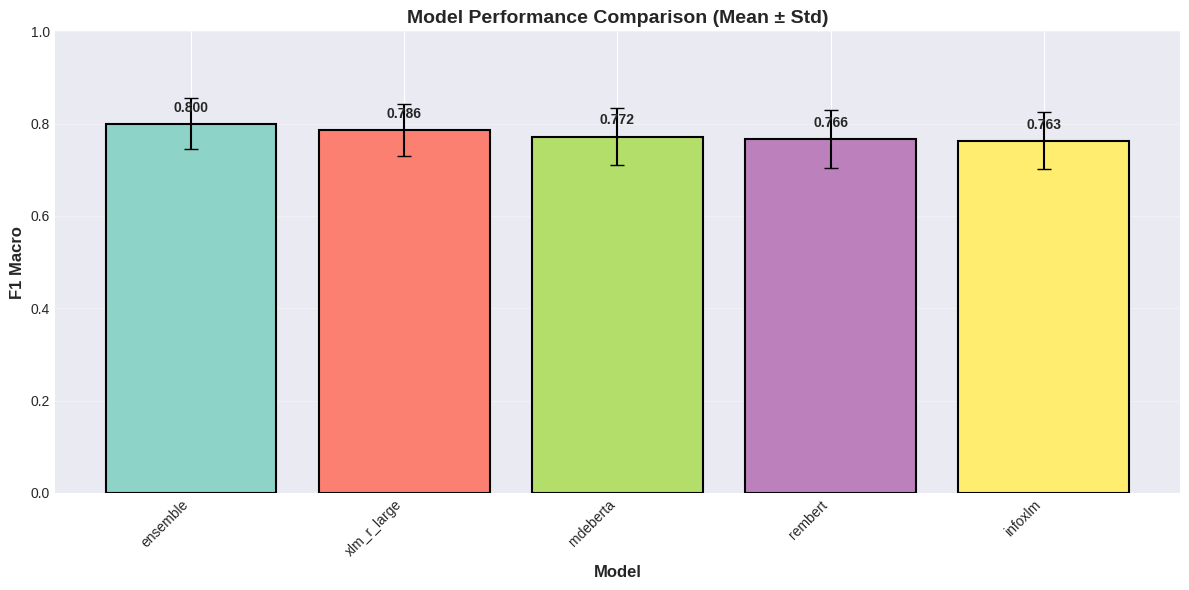


2. ENSEMBLE PERFORMANCE SUMMARY

ENSEMBLE - OVERALL PERFORMANCE SUMMARY
Number of languages: 22

F1-Score (Macro):
  Mean:   0.7998
  Median: 0.7974
  Std:    0.0554
  Min:    0.6573
  Max:    0.9002

Precision (Macro):
  Mean:   0.8068

Recall (Macro):
  Mean:   0.7965


3. PER-LANGUAGE PERFORMANCE ANALYSIS


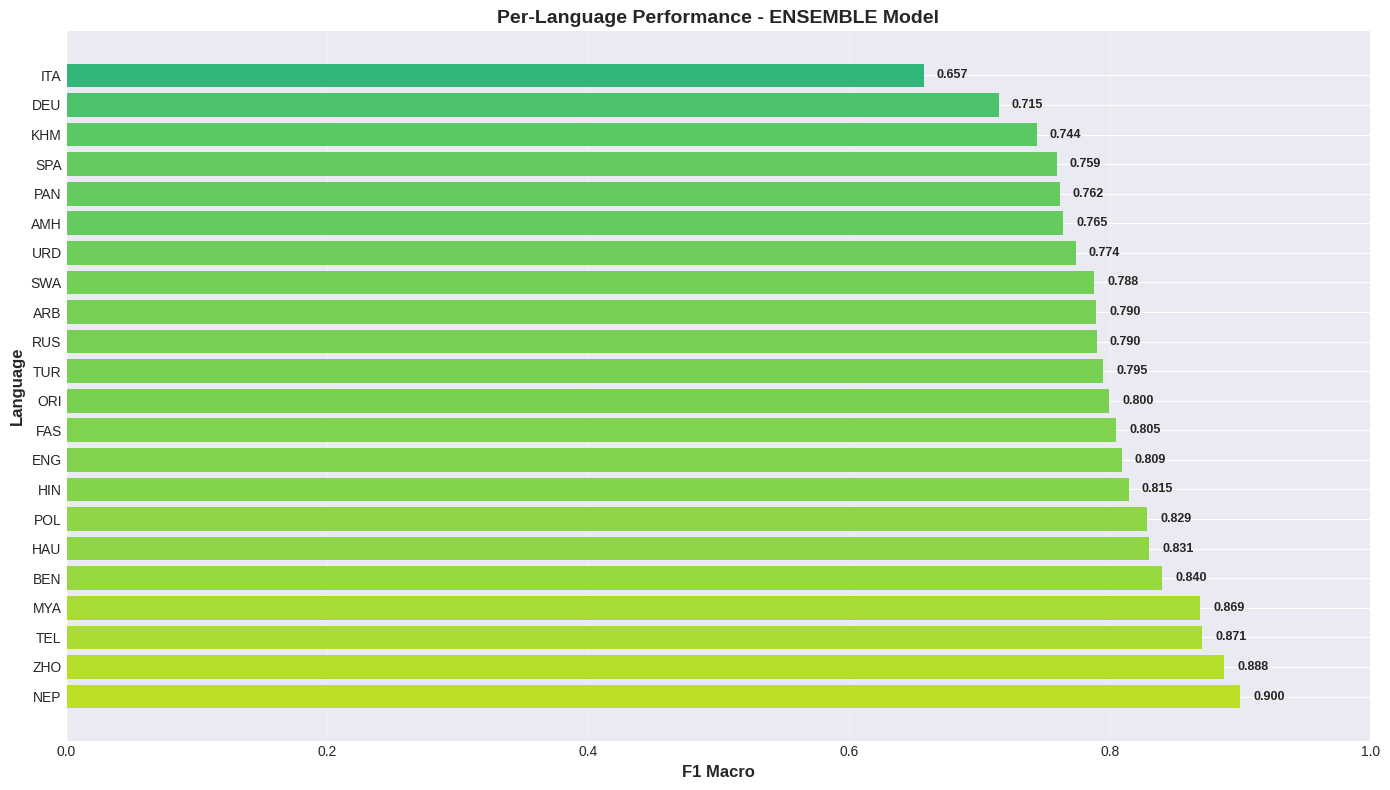


F1_MACRO Statistics:
Mean:   0.7998
Median: 0.7974
Std:    0.0554
Min:    0.6573 (ITA)
Max:    0.9002 (NEP)

4. CONFUSION MATRICES (BEST & WORST LANGUAGES)


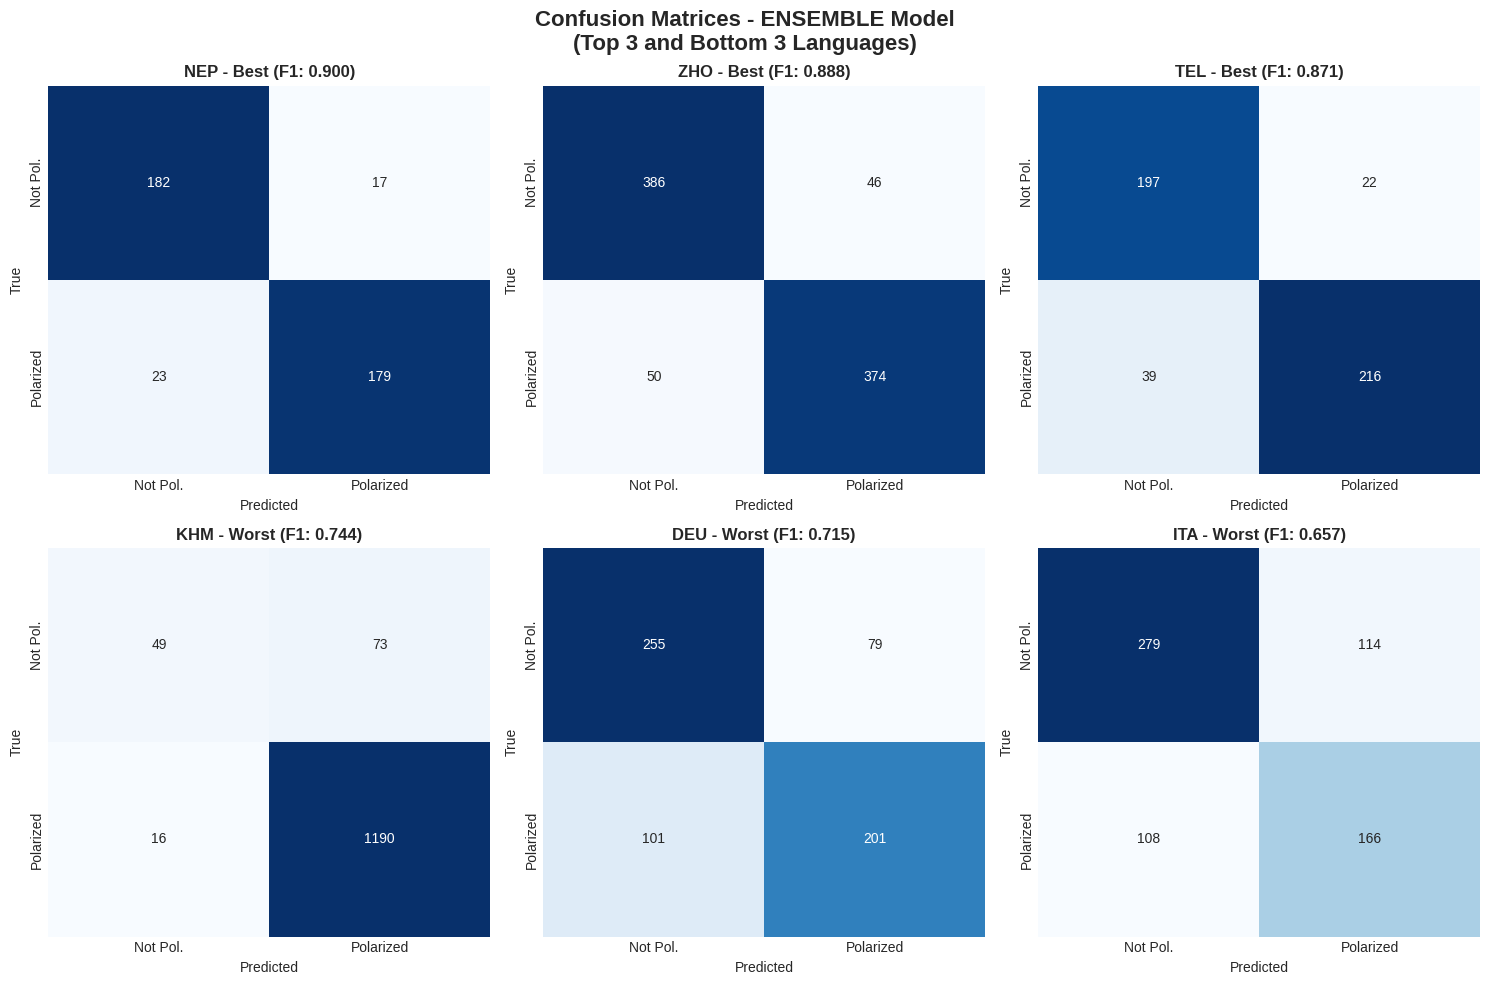


5. DETAILED RESULTS TABLE

DETAILED RESULTS TABLE - ENSEMBLE
Language  F1-Macro  Precision  Recall  Accuracy  Samples
     NEP    0.9002     0.9005  0.9004    0.9002      401
     ZHO    0.8878     0.8879  0.8878    0.8879      856
     TEL    0.8711     0.8712  0.8733    0.8713      474
     MYA    0.8695     0.8673  0.8731    0.8720      578
     BEN    0.8403     0.8413  0.8394    0.8441      667
     HAU    0.8305     0.8577  0.8083    0.9398      731
     POL    0.8288     0.8338  0.8255    0.8351      479
     HIN    0.8147     0.8019  0.8295    0.9035      549
     ENG    0.8093     0.8122  0.8068    0.8248      645
     FAS    0.8049     0.8043  0.8055    0.8498      659
     ORI    0.7998     0.8142  0.7891    0.8418      474
     TUR    0.7949     0.7949  0.7951    0.7949      473
     RUS    0.7902     0.8002  0.7825    0.8269      670
     ARB    0.7897     0.7891  0.7908    0.7914      676
     SWA    0.7881     0.7903  0.7885    0.7884     1399
     URD    0.7740     0.7

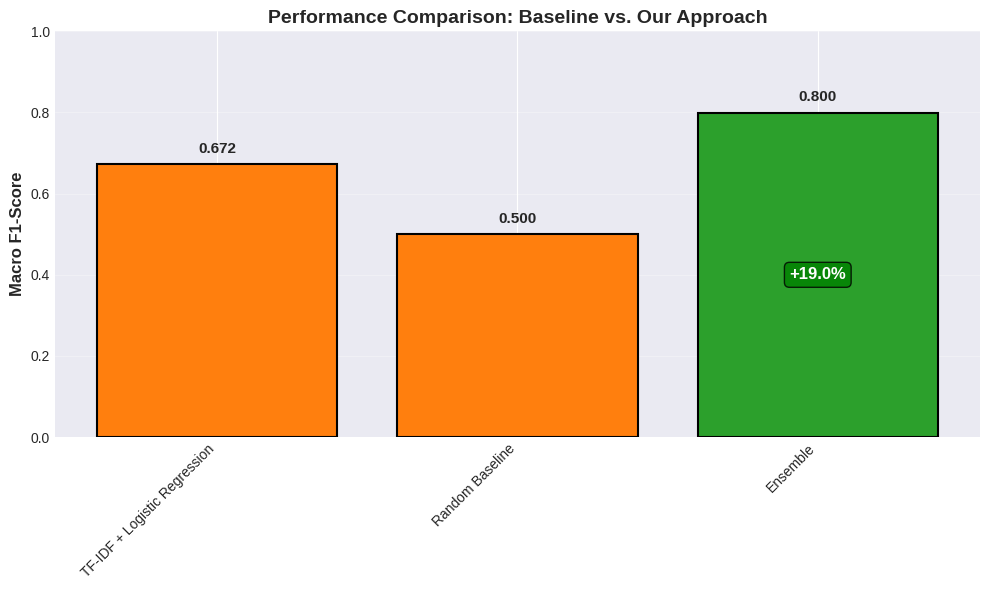


BASELINE COMPARISON
TF-IDF + Logistic Regression  : 0.6720
Random Baseline               : 0.5000
Ensemble                      : 0.7998

Improvement over baseline: +19.02%


EVALUATION COMPLETE!


In [22]:
# ============================================================================
# PART 14: COMPREHENSIVE RESULTS & EVALUATION
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score
)
import json
from pathlib import Path

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# FUNCTION: Load Results from Checkpoint Files
# ============================================================================
def load_evaluation_results(checkpoint_dir='checkpoints'):
    """
    Load saved evaluation results from training.
    Returns per-language results for all models and ensemble.
    """
    results = {}
    checkpoint_path = Path(checkpoint_dir)

    # Load individual model results (saved as model_name_per_language_results.json)
    model_names = ['xlm_r_base', 'xlm_r_large', 'mdeberta', 'infoxlm', 'rembert']
    for model in model_names:
        result_file = checkpoint_path / f'{model}_per_language_results.json'
        if result_file.exists():
            with open(result_file, 'r') as f:
                results[model] = json.load(f)
            print(f"Loaded {model}: {len(results[model])} languages")

    # Try multiple possible filenames
    possible_ensemble_files = [
        'ensemble_ensemble_results.json',
        'ensemble_per_language_results.json',
        'ensemble_results.json'
    ]

    for filename in possible_ensemble_files:
        ensemble_file = checkpoint_path / filename
        if ensemble_file.exists():
            with open(ensemble_file, 'r') as f:
                results['ensemble'] = json.load(f)
            print(f"Loaded ensemble from: {filename} ({len(results['ensemble'])} languages)")
            break

    if 'ensemble' not in results:
        print("WARNING: Ensemble results not found! Checked:")
        for filename in possible_ensemble_files:
            print(f"  - {checkpoint_path / filename}")

    print(f"\nTotal models loaded: {len(results)}")
    return results

# ============================================================================
# FUNCTION: Generate Confusion Matrix
# ============================================================================
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix',
                         labels=['Not Polarized', 'Polarized'],
                         save_path=None):
    """
    Generate and display confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Print additional metrics
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{title} - Detailed Metrics:")
    print(f"True Negatives:  {tn:,}")
    print(f"False Positives: {fp:,}")
    print(f"False Negatives: {fn:,}")
    print(f"True Positives:  {tp:,}")
    print(f"Total Samples:   {tn+fp+fn+tp:,}")

# ============================================================================
# FUNCTION: Generate Confusion Matrices for Languages
# ============================================================================
def plot_language_confusion_matrices(results_dict, model_name='ensemble',
                                    max_languages=6):
    """
    Generate confusion matrices for best and worst performing languages.
    """
    if model_name not in results_dict:
        print(f"ERROR: Model '{model_name}' not found in results!")
        print(f"Available models: {list(results_dict.keys())}")
        return

    lang_results = results_dict[model_name]

    # Sort languages by F1 score
    sorted_langs = sorted(lang_results.items(),
                         key=lambda x: x[1].get('f1_macro', 0),
                         reverse=True)

    # Select top 3 and bottom 3
    selected_langs = sorted_langs[:3] + sorted_langs[-3:]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Confusion Matrices - {model_name.upper()} Model\n(Top 3 and Bottom 3 Languages)',
                 fontsize=16, fontweight='bold')

    for idx, (lang, metrics) in enumerate(selected_langs):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]

        if 'confusion_matrix' in metrics:
            cm = np.array(metrics['confusion_matrix'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       xticklabels=['Not Pol.', 'Polarized'],
                       yticklabels=['Not Pol.', 'Polarized'],
                       cbar=False)
            f1 = metrics.get('f1_macro', 0)
            rank = "Best" if idx < 3 else "Worst"
            ax.set_title(f"{lang.upper()} - {rank} (F1: {f1:.3f})", fontweight='bold')
            ax.set_ylabel('True')
            ax.set_xlabel('Predicted')
        else:
            ax.text(0.5, 0.5, f'No confusion matrix\nfor {lang.upper()}',
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'{model_name}_language_confusion_matrices.png',
                dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# FUNCTION: Display Macro Metrics Summary
# ============================================================================
def display_model_summary(results_dict, model_name='ensemble'):
    """
    Display overall summary statistics for a model.
    """
    if model_name not in results_dict:
        print(f"Model '{model_name}' not found!")
        return

    lang_results = results_dict[model_name]

    # Extract all F1 scores
    f1_scores = [m.get('f1_macro', 0) for m in lang_results.values()]
    precision_scores = [m.get('precision_macro', 0) for m in lang_results.values()]
    recall_scores = [m.get('recall_macro', 0) for m in lang_results.values()]

    print(f"\n{'='*60}")
    print(f"{model_name.upper()} - OVERALL PERFORMANCE SUMMARY")
    print(f"{'='*60}")
    print(f"Number of languages: {len(lang_results)}")
    print(f"\nF1-Score (Macro):")
    print(f"  Mean:   {np.mean(f1_scores):.4f}")
    print(f"  Median: {np.median(f1_scores):.4f}")
    print(f"  Std:    {np.std(f1_scores):.4f}")
    print(f"  Min:    {np.min(f1_scores):.4f}")
    print(f"  Max:    {np.max(f1_scores):.4f}")

    if precision_scores[0] > 0:  # Check if precision is available
        print(f"\nPrecision (Macro):")
        print(f"  Mean:   {np.mean(precision_scores):.4f}")
        print(f"\nRecall (Macro):")
        print(f"  Mean:   {np.mean(recall_scores):.4f}")

    print(f"{'='*60}\n")

    return {
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores),
        'precision_mean': np.mean(precision_scores),
        'recall_mean': np.mean(recall_scores)
    }

# ============================================================================
# FUNCTION: Per-Language Performance Bar Chart
# ============================================================================
def plot_language_performance(results_dict, metric='f1_macro',
                              model_name='ensemble', save_path=None):
    """
    Create bar chart showing per-language performance.
    """
    if model_name not in results_dict:
        print(f"Model '{model_name}' not found!")
        print(f"Available: {list(results_dict.keys())}")
        return

    lang_results = results_dict[model_name]

    # Extract language codes and scores
    languages = []
    scores = []

    for lang, metrics in sorted(lang_results.items(),
                               key=lambda x: x[1].get(metric, 0),
                               reverse=True):
        languages.append(lang.upper())
        scores.append(metrics.get(metric, 0))

    # Create bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = ax.barh(languages, scores, color=plt.cm.viridis(np.array(scores)))

    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax.text(score + 0.01, i, f'{score:.3f}',
               va='center', fontsize=9, fontweight='bold')

    ax.set_xlabel(f'{metric.replace("_", " ").title()}',
                  fontsize=12, fontweight='bold')
    ax.set_ylabel('Language', fontsize=12, fontweight='bold')
    ax.set_title(f'Per-Language Performance - {model_name.upper()} Model',
                fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1.0])
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistics
    print(f"\n{metric.upper()} Statistics:")
    print(f"Mean:   {np.mean(scores):.4f}")
    print(f"Median: {np.median(scores):.4f}")
    print(f"Std:    {np.std(scores):.4f}")
    print(f"Min:    {np.min(scores):.4f} ({languages[np.argmin(scores)]})")
    print(f"Max:    {np.max(scores):.4f} ({languages[np.argmax(scores)]})")

# ============================================================================
# FUNCTION: Model Comparison Table and Chart
# ============================================================================
def create_model_comparison_table(results_dict, metric='f1_macro'):
    """
    Create comparison table showing all models' performance.
    """
    # Calculate average performance for each model
    model_scores = {}

    for model_name, lang_results in results_dict.items():
        scores = [metrics.get(metric, 0) for metrics in lang_results.values()]
        model_scores[model_name] = {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'min': np.min(scores),
            'max': np.max(scores),
            'num_langs': len(scores)
        }

    # Create DataFrame
    df = pd.DataFrame(model_scores).T
    df = df.sort_values('mean', ascending=False)

    print(f"\n{'='*80}")
    print(f"MODEL COMPARISON - {metric.replace('_', ' ').upper()}")
    print(f"{'='*80}")
    print(df.to_string(float_format='%.4f'))
    print(f"{'='*80}\n")

    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(df))
    bars = ax.bar(x, df['mean'], yerr=df['std'], capsize=5,
                  color=plt.cm.Set3(np.linspace(0, 1, len(df))),
                  edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{metric.replace("_", " ").title()}',
                  fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Comparison (Mean ± Std)',
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])

    # Add value labels
    for bar, mean_val in zip(bars, df['mean']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
               f'{mean_val:.3f}', ha='center', va='bottom',
               fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    return df

# ============================================================================
# FUNCTION: Baseline Comparison
# ============================================================================
def create_baseline_comparison(results_dict, baseline_scores):
    """
    Compare ensemble against baseline approaches.
    """
    if 'ensemble' not in results_dict:
        print("Ensemble results not found! Skipping baseline comparison.")
        return

    # Calculate ensemble performance
    ensemble_results = results_dict['ensemble']
    ensemble_scores = [m.get('f1_macro', 0) for m in ensemble_results.values()]
    ensemble_mean = np.mean(ensemble_scores)

    # Prepare data
    all_models = list(baseline_scores.keys()) + ['Ensemble']
    all_scores = list(baseline_scores.values()) + [ensemble_mean]

    # Create comparison plot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#ff7f0e'] * len(baseline_scores) + ['#2ca02c']  # Orange for baselines, green for ours
    bars = ax.bar(all_models, all_scores, color=colors,
                  edgecolor='black', linewidth=1.5)

    ax.set_ylabel('Macro F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('Performance Comparison: Baseline vs. Our Approach',
                fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

    # Add value labels and improvement percentages
    for i, (bar, score) in enumerate(zip(bars, all_scores)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
               f'{score:.3f}', ha='center', va='bottom',
               fontweight='bold', fontsize=11)

        # Show improvement over first baseline
        if i == len(all_models) - 1:
            baseline_score = list(baseline_scores.values())[0]
            improvement = ((score - baseline_score) / baseline_score) * 100
            ax.text(bar.get_x() + bar.get_width()/2., height/2,
                   f'+{improvement:.1f}%', ha='center', va='center',
                   fontweight='bold', fontsize=12, color='white',
                   bbox=dict(boxstyle='round', facecolor='green', alpha=0.8))

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('baseline_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n{'='*60}")
    print("BASELINE COMPARISON")
    print(f"{'='*60}")
    for model, score in zip(all_models, all_scores):
        print(f"{model:30s}: {score:.4f}")
    baseline_score = list(baseline_scores.values())[0]
    improvement = ((ensemble_mean - baseline_score) / baseline_score) * 100
    print(f"\nImprovement over baseline: +{improvement:.2f}%")
    print(f"{'='*60}\n")

# ============================================================================
# FUNCTION: Create Performance Table for Report
# ============================================================================
def create_detailed_results_table(results_dict, model_name='ensemble'):
    """
    Create a detailed table of per-language results suitable for report.
    """
    if model_name not in results_dict:
        print(f"Model '{model_name}' not found!")
        return

    lang_results = results_dict[model_name]

    # Create DataFrame
    data = []
    for lang, metrics in sorted(lang_results.items()):
        data.append({
            'Language': lang.upper(),
            'F1-Macro': metrics.get('f1_macro', 0),
            'Precision': metrics.get('precision_macro', 0),
            'Recall': metrics.get('recall_macro', 0),
            'Accuracy': metrics.get('accuracy', 0),
            'Samples': metrics.get('num_samples', 0)
        })

    df = pd.DataFrame(data)
    df = df.sort_values('F1-Macro', ascending=False)

    print(f"\n{'='*80}")
    print(f"DETAILED RESULTS TABLE - {model_name.upper()}")
    print(f"{'='*80}")
    print(df.to_string(index=False, float_format='%.4f'))
    print(f"{'='*80}\n")

    # Save to CSV for easy import to report
    csv_path = f'{model_name}_detailed_results.csv'
    df.to_csv(csv_path, index=False, float_format='%.4f')
    print(f"Saved detailed table to: {csv_path}")

    return df

# ============================================================================
# MAIN EXECUTION: Generate All Visualizations
# ============================================================================

print("="*80)
print("GENERATING COMPREHENSIVE EVALUATION RESULTS")
print("="*80)

# Load results
results = load_evaluation_results('checkpoints')

if not results:
    print("\nERROR: No results found!")
    print("Make sure training has completed and checkpoint files exist.")
    print("Expected location: checkpoints/")
else:
    print(f"\nSuccessfully loaded results for {len(results)} model(s)\n")

    # Check if ensemble exists
    has_ensemble = 'ensemble' in results

    # 1. MODEL COMPARISON (if multiple models)
    if len(results) > 1:
        print("\n" + "="*80)
        print("1. MODEL COMPARISON")
        print("="*80)
        comparison_df = create_model_comparison_table(results, metric='f1_macro')

    # 2. ENSEMBLE SUMMARY (if available)
    if has_ensemble:
        print("\n" + "="*80)
        print("2. ENSEMBLE PERFORMANCE SUMMARY")
        print("="*80)
        ensemble_summary = display_model_summary(results, model_name='ensemble')

        # 3. PER-LANGUAGE PERFORMANCE
        print("\n" + "="*80)
        print("3. PER-LANGUAGE PERFORMANCE ANALYSIS")
        print("="*80)
        plot_language_performance(results, metric='f1_macro',
                                 model_name='ensemble',
                                 save_path='language_performance.png')

        # 4. CONFUSION MATRICES
        print("\n" + "="*80)
        print("4. CONFUSION MATRICES (BEST & WORST LANGUAGES)")
        print("="*80)
        plot_language_confusion_matrices(results, model_name='ensemble', max_languages=6)

        # 5. DETAILED RESULTS TABLE
        print("\n" + "="*80)
        print("5. DETAILED RESULTS TABLE")
        print("="*80)
        detailed_df = create_detailed_results_table(results, model_name='ensemble')

        # 6. BASELINE COMPARISON
        print("\n" + "="*80)
        print("6. BASELINE COMPARISON")
        print("="*80)
        baseline_scores = {
            'TF-IDF + Logistic Regression': 0.672,
            'Random Baseline': 0.500
        }
        create_baseline_comparison(results, baseline_scores)
    else:
        print("\nWARNING: Ensemble results not found!")
        print("Generating visualizations for available models only...")

        # Use first available model
        first_model = list(results.keys())[0]
        print(f"\nUsing '{first_model}' for visualizations")

        display_model_summary(results, model_name=first_model)
        plot_language_performance(results, metric='f1_macro',
                                 model_name=first_model,
                                 save_path=f'{first_model}_language_performance.png')
        plot_language_confusion_matrices(results, model_name=first_model)
        create_detailed_results_table(results, model_name=first_model)

    print("\n" + "="*80)
    print("EVALUATION COMPLETE!")
    print("="*80)
